In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import shap
import warnings


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [90]:
# --- STEP 1: LOAD CSV ---
print("--- Step 1: Loading csv file ---")
df1 = pd.read_csv("./data/data_4.csv")
print("DataFrame loaded successfully.")

--- Step 1: Loading csv file ---
DataFrame loaded successfully.


In [91]:
df1.head()

,subtotal,packaging_charges,promo_discount,restro_discount,total,rest_lat,rest_lon,Distance_km,temperature,humidity,precipitation,wind_speed,weather_condition,upto,flat_%,flat_rs,buy_1_get_1,buy_7_get_3,hour,day,month,day_of_month
0,715.0,31.75,80.0,0.0,666.75,28.5734,77.2581,3.0,26.0,96.0,0.0,0.0,Cloudy,80.0,0.0,0.0,0,0,23,1,9,10
1,1179.0,50.20,175.0,0.0,1054.20,28.5734,77.2581,2.0,26.0,96.0,0.0,0.0,Cloudy,0.0,0.0,175.0,0,0,23,1,9,10
2,310.0,11.50,80.0,0.0,241.50,28.5734,77.2581,0.9,26.1,95.0,0.0,0.0,Cloudy,80.0,0.0,0.0,0,0,15,1,9,10
3,620.0,27.00,80.0,0.0,567.00,28.5734,77.2581,2.0,26.1,95.0,0.0,0.0,Cloudy,80.0,0.0,0.0,0,0,15,1,9,10
4,584.0,25.20,80.0,0.0,529.20,28.5734,77.2581,2.0,26.1,95.0,0.0,0.0,Cloudy,80.0,0.0,0.0,0,0,15,1,9,10


In [92]:
# Define Target and Features
target_col = 'subtotal'
feature_cols = [
    'restro_discount', 'upto', 'flat_%', 'flat_rs', 'buy_1_get_1', 'buy_7_get_3',
    'rest_lat', 'rest_lon', 'Distance_km', 'temperature', 'humidity', 'precipication', 'wind_speed', 'weather_condition',
    'hour', 'day', 'hour', 'day', 'month', 'day_of_month'
]

# Ensure all feature columns exist
feature_cols = [col for col in feature_cols if col in df1.columns]

y = df1[target_col]
X = pd.get_dummies(df1[feature_cols], columns=['hour', 'day', 'month', 'day_of_month', 'weather_condition'], drop_first=True)

In [93]:
X.info() #checking for nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20673 entries, 0 to 20672
Data columns (total 97 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   restro_discount           20673 non-null  float64
 1   upto                      20673 non-null  float64
 2   flat_%                    20673 non-null  float64
 3   flat_rs                   20673 non-null  float64
 4   buy_1_get_1               20673 non-null  int64  
 5   buy_7_get_3               20673 non-null  int64  
 6   rest_lat                  20673 non-null  float64
 7   rest_lon                  20673 non-null  float64
 8   Distance_km               20673 non-null  float64
 9   temperature               20673 non-null  float64
 10  humidity                  20673 non-null  float64
 11  wind_speed                20673 non-null  float64
 12  hour_1                    20673 non-null  bool   
 13  hour_2                    20673 non-null  bool   
 14  hour_3

In [94]:
y.info() #checking for nan

<class 'pandas.core.series.Series'>
RangeIndex: 20673 entries, 0 to 20672
Series name: subtotal
Non-Null Count  Dtype  
--------------  -----  
20673 non-null  float64
dtypes: float64(1)
memory usage: 161.6 KB


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data preprocessed and split.\n")

# --- STEP 2: TRAIN RANDOM FOREST WITH GRIDSEARCHCV ---
print("--- Step 2: Running GridSearchCV for Random Forest ---")
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [600, 800],      
    'max_depth': [8, 10],
    'min_samples_leaf': [4,6],
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print("Model training complete.\n")

Data preprocessed and split.

--- Step 2: Running GridSearchCV for Random Forest ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits


Model training complete.



In [96]:
# --- STEP 3: EVALUATE THE BEST MODEL ---
print("--- Step 3: Model Evaluation ---")
y_pred = best_rf_model.predict(X_test)
r2_score_rf = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Random Forest R-squared: {r2_score_rf:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Rs")
print(f"Best Parameters Found: {grid_search.best_params_}\n")

--- Step 3: Model Evaluation ---
Random Forest R-squared: 0.4613
Mean Squared Error (MSE): 154177.30
Root Mean Squared Error (RMSE): 392.65 Rs
Best Parameters Found: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 800}



--- Step 4: Generating SHAP Summary Plot ---
SHAP explainer and values calculated successfully.

Displaying SHAP Summary Plot...


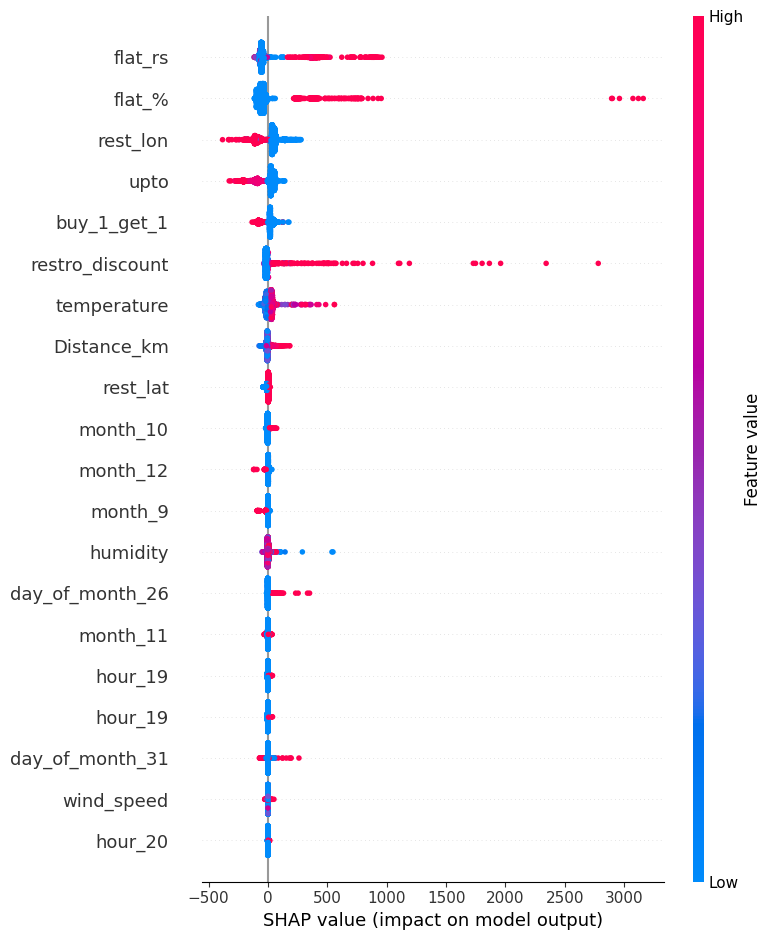

In [97]:
# --- STEP 4: GENERATE SHAP SUMMARY PLOT ---
print("--- Step 4: Generating SHAP Summary Plot ---")

explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)
# In a script, we'd save the plot instead of showing it
print("SHAP explainer and values calculated successfully.\n")

print("Displaying SHAP Summary Plot...")
shap.summary_plot(
shap_values,
X_test,
plot_type="dot" # This "beeswarm" plot is the best
)

In [98]:
# --- STEP 5: GENERATE SHAP INFERENCE REPORT ---
print("--- Step 5: Generating SHAP Inference Report ---")
promo_feature_list = [
    'upto',
    'flat_%',
    'flat_rs',
    'buy_1_get_1',
    'buy_7_get_3'
]

shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

base_subtotal = explainer.expected_value
if isinstance(base_subtotal, np.ndarray):
    base_subtotal = base_subtotal[0]

print(f"Baseline (Average) Subtotal: {base_subtotal:.2f} Rs\n")

for promo_name in promo_feature_list:
    if promo_name not in X_test.columns:
        print(f"Warning: '{promo_name}' not in X_test. Skipping.")
        continue

    promo_on_indices = (X_test[promo_name] > 0).values

    if promo_on_indices.sum() == 0:
        print(f"--- Feature: {promo_name} ---")
        print("  (Promo was not used in the test set)\n")
        continue

    shap_values_for_promo_on = shap_df.loc[promo_on_indices, promo_name]
    average_rupee_effect = shap_values_for_promo_on.mean()

    if base_subtotal != 0:
        average_percentage_effect = (average_rupee_effect / base_subtotal) * 100
    else:
        average_percentage_effect = np.nan

    print(f"--- Feature: {promo_name} ---")
    print(f"  Avg. Impact (Rupees): {average_rupee_effect:.2f} Rs")
    print(f"  Avg. Impact (%): {average_percentage_effect:.2f}%\n")

--- Step 5: Generating SHAP Inference Report ---
Baseline (Average) Subtotal: 750.09 Rs

--- Feature: upto ---
  Avg. Impact (Rupees): -119.61 Rs
  Avg. Impact (%): -15.95%

--- Feature: flat_% ---
  Avg. Impact (Rupees): 454.07 Rs
  Avg. Impact (%): 60.54%

--- Feature: flat_rs ---
  Avg. Impact (Rupees): 203.76 Rs
  Avg. Impact (%): 27.16%

--- Feature: buy_1_get_1 ---
  Avg. Impact (Rupees): -71.50 Rs
  Avg. Impact (%): -9.53%

--- Feature: buy_7_get_3 ---
  (Promo was not used in the test set)

